In [ ]:
# Этап 1. Генерация данных
# Для генераии данных возможно выбрать поднабор изображений в количестве 10-50 шт, "нарезку" патчей выполнить по ним.
# Изучите набор данных, располагающийся в архиве blood_cells.
# Выполните "нарезку" изображений. Сохраните в отдельные папки изображения фона и изображения клеток.
# Реализуйте генератор данных снимков клеток крови. На выходе генератор предосталвяет два изображения: сгенерированное без шума, сгенерированное с шумом.
# Патчи для формирования фона: 
# 1) патчи, вырезанные из исходного набора данных 
# 2) искусственно сформированные патчи (равномерная заливка фона из диапазона допустимых значений)
# Фон изображения формируется из набора патчей. 
# Патчи для клеток крови:
# 1) патчи, вырезанные из исходного набора данных
# 2) искусствено сгенерированные окружности с заливкой из допустимого набора данных
# для blending-задачи применять: https://learnopencv.com/seamless-cloning-using-opencv-python-cpp/
# Примеры генераторов и загрузчиков данных найдете в исходной папке.
##########
# Основные этапы генерации:
# 1. Выбор, формирование патчей, их препроцессинг. Формирование(комбинирование) фона из набора патчей. Постпроцессинг результирующего фона.
# 2. Выбор метоположения клекток, выбор/формирование клеток, совмещение клеток на фоновом изображении
# 3. Выбор типа шума. Зашумление изображения. 
#
# Генератор возвращает два изображения: зашумленное (этап 3) и исходное (этап 2) изображения.
#
# Этап 2. Исследование качества работы алгоритмов шумоподавления на сформированном датасете.
# Виды шумов:
# 1) Шум Гаусса
# 2) постоянный шум
# Виды фильтров:
# 1) Медианный фильтр
# 2) фильтр гаусса
# 3) билатериальный фильтр 
# 4) фильтр нелокальных средних с различными параметрами.
# 5.1) самостоятелная реализация алгоритма шумоподавления (CPU)
# 5.2) самостоятелная реализация алгоритма шумоподавления (GPU)
# Метрики:
# 1) MSE
# 2) SSIM
# 3) время работы
# 

In [25]:
import os

dataset_path = "/Users/zuhroabdulloeva/Desktop/4 КУРС/cv/blood_cells_dataset/"

def print_dataset_structure(path):
    for root, dirs, files in os.walk(path):
        print(f"Текущая папка: {root}")
        if files:
            print("  Файлы:")
            for file in files:
                print(f"    {file}")
        if dirs:
            print("  Подкаталоги:")
            for dir in dirs:
                print(f"    {dir}")
print_dataset_structure(dataset_path)

Текущая папка: /Users/zuhroabdulloeva/Desktop/4 КУРС/cv/blood_cells_dataset/
  Файлы:
    .DS_Store
  Подкаталоги:
    patch
    fon
Текущая папка: /Users/zuhroabdulloeva/Desktop/4 КУРС/cv/blood_cells_dataset/patch
  Файлы:
    patch8.png
    patch9.png
    patch13.png
    patch12.png
    patch10.png
    patch11.png
    patch15.png
    patch14.png
    patch16.png
    patch2.png
    patch3.png
    patch1.png
    patch4.png
    patch5.png
    patch7.png
    patch6.png
Текущая папка: /Users/zuhroabdulloeva/Desktop/4 КУРС/cv/blood_cells_dataset/fon
  Файлы:
    fon20.png
    fon21.png
    fon19.png
    fon18.png
    fon9.png
    fon8.png
    fon5.png
    fon4.png
    fon6.png
    fon7.png
    fon3.png
    fon2.png
    fon1.png
    fon15.png
    fon14.png
    fon16.png
    fon17.png
    fon13.png
    fon12.png
    fon10.png
    fon11.png


In [13]:
import zipfile
import os

zip_path = "/Users/zuhroabdulloeva/Desktop/4 КУРС/cv/blood_cells_dataset.zip"  
extract_path = "/Users/zuhroabdulloeva/Desktop/4 КУРС/cv"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Файлы успешно распакованы в:", extract_path)

Файлы успешно распакованы в: /Users/zuhroabdulloeva/Desktop/4 КУРС/cv


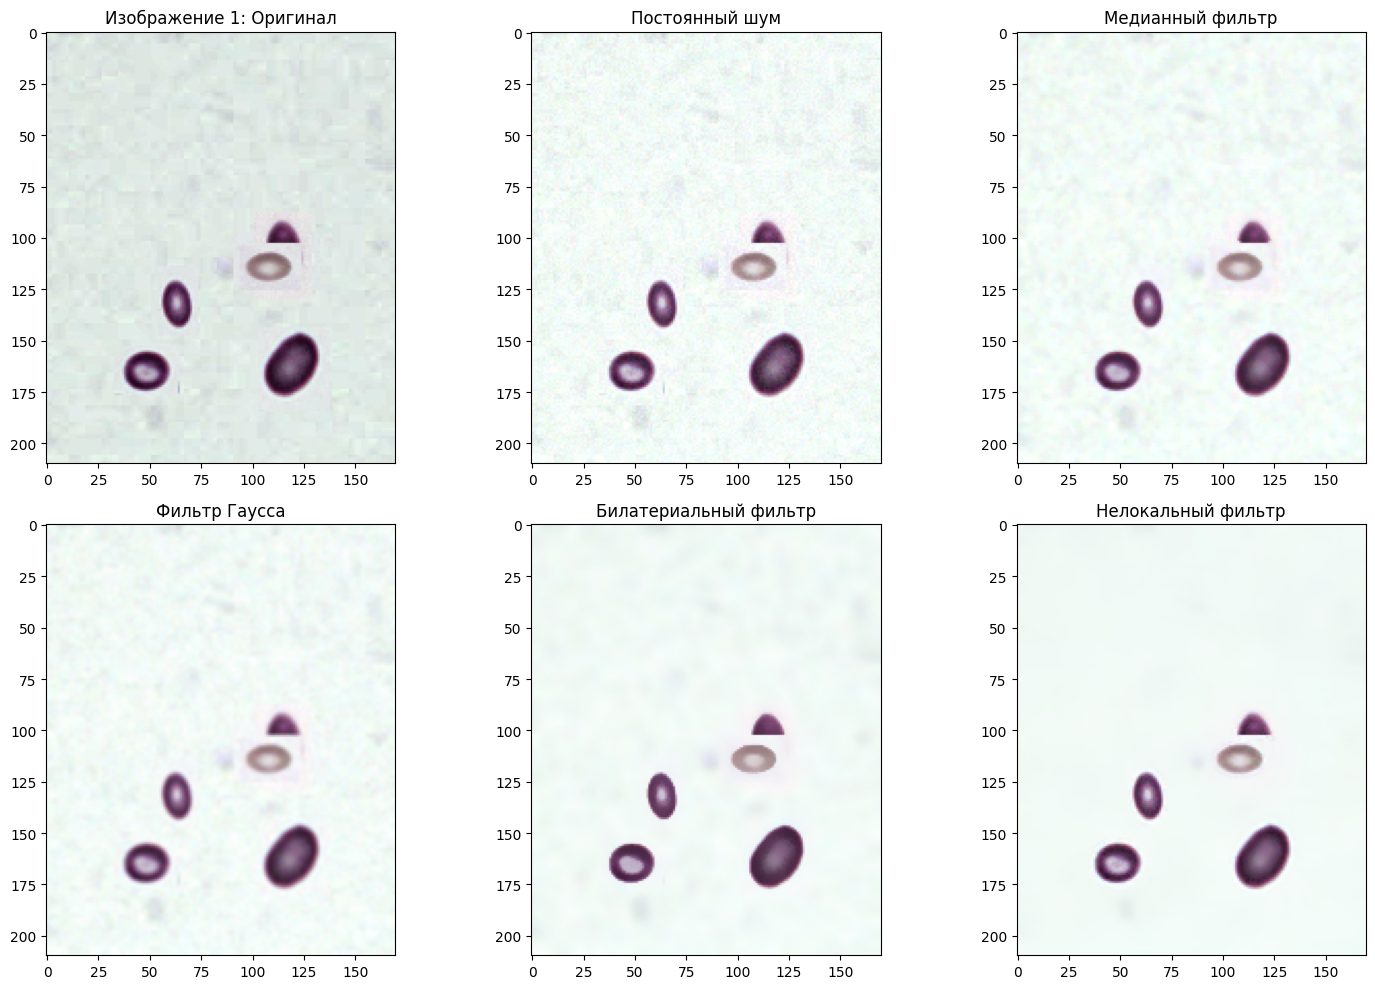


Метрики качества фильтрации для Изображение 1:
Медианный фильтр: MSE=389.29, SSIM=nan
Фильтр Гаусса: MSE=374.42, SSIM=nan
Билатериальный фильтр: MSE=374.28, SSIM=nan
Нелокальный фильтр: MSE=379.73, SSIM=nan


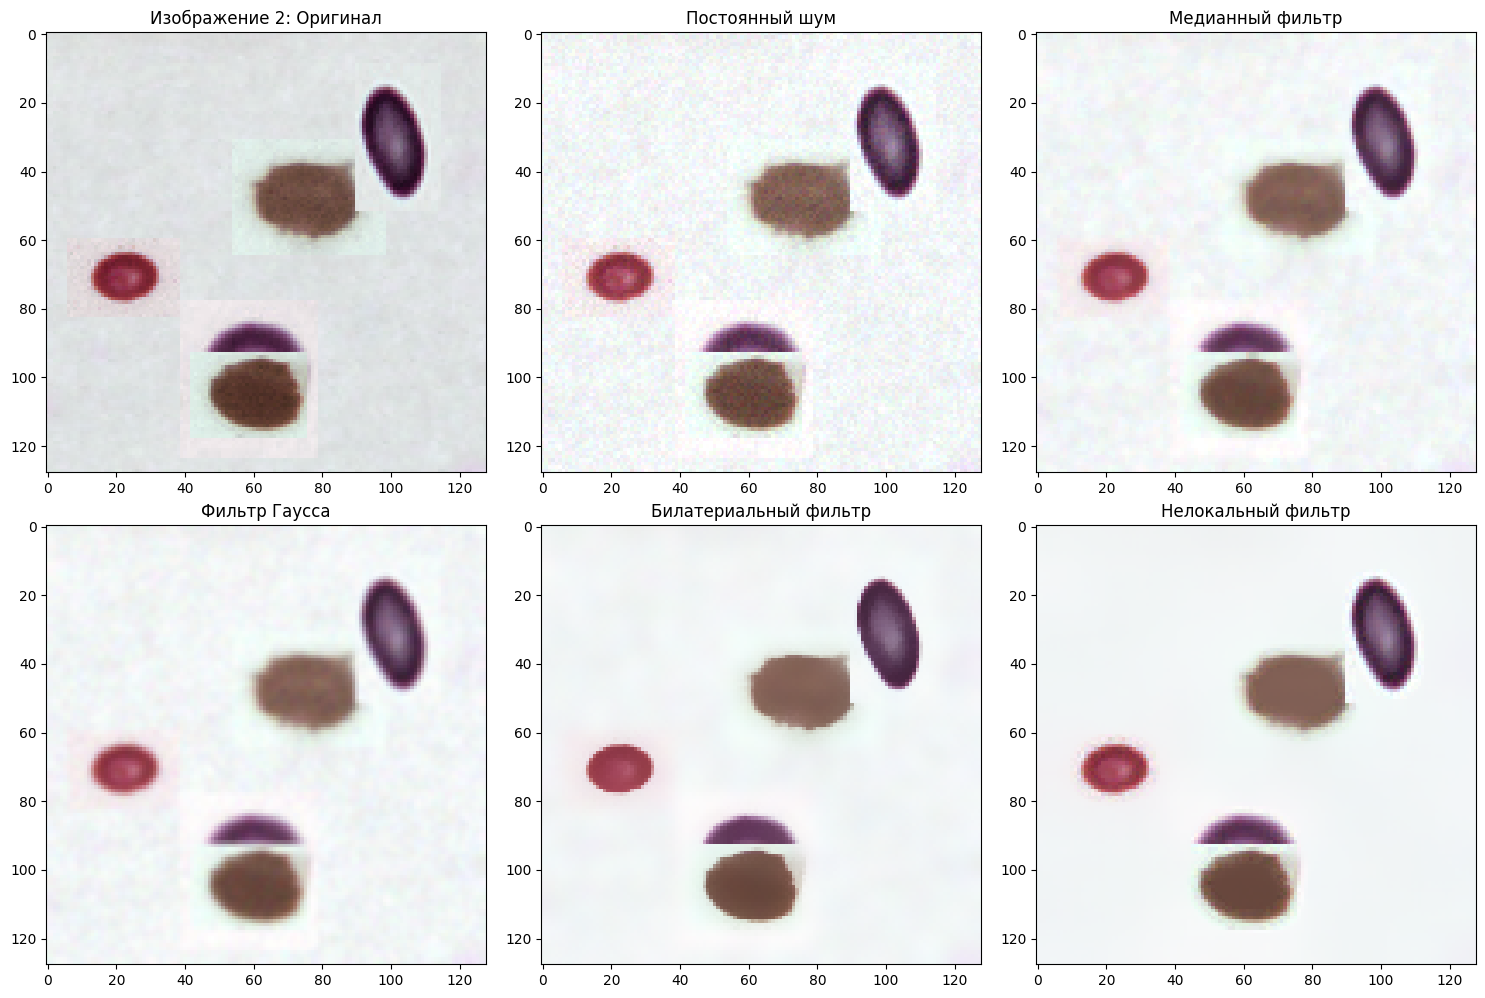


Метрики качества фильтрации для Изображение 2:
Медианный фильтр: MSE=395.98, SSIM=nan
Фильтр Гаусса: MSE=394.73, SSIM=nan
Билатериальный фильтр: MSE=391.17, SSIM=nan
Нелокальный фильтр: MSE=384.40, SSIM=nan


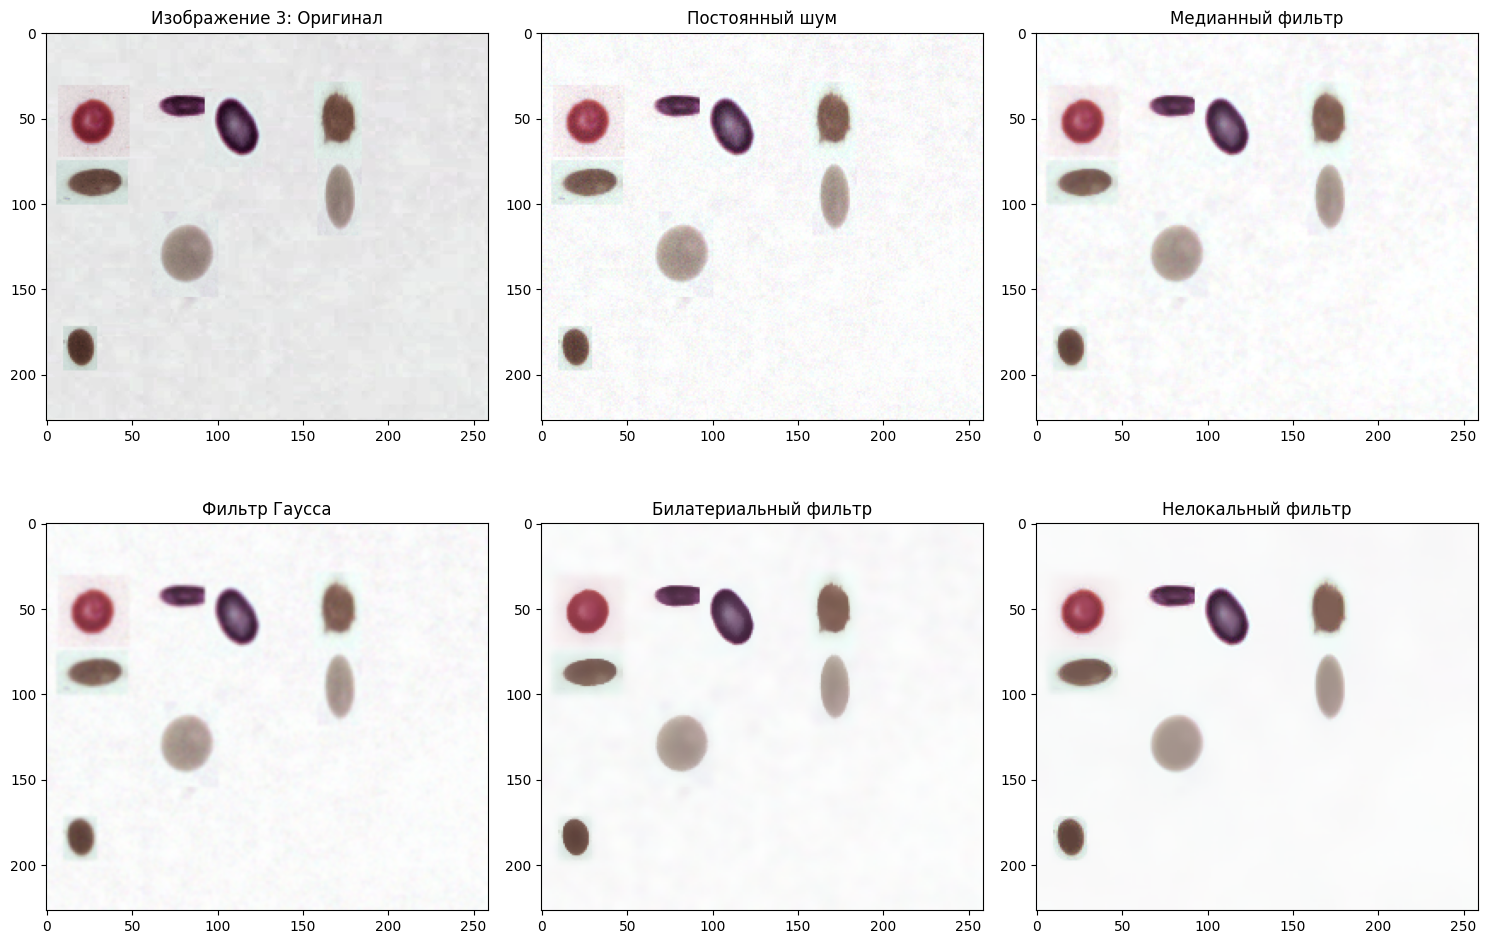


Метрики качества фильтрации для Изображение 3:
Медианный фильтр: MSE=381.78, SSIM=nan
Фильтр Гаусса: MSE=354.48, SSIM=nan
Билатериальный фильтр: MSE=354.37, SSIM=nan
Нелокальный фильтр: MSE=357.06, SSIM=nan


In [8]:
import os
import numpy as np
import cv2
import random
import time
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, mean_squared_error
import math

# Пути к папкам с фоном и клетками
fon_path = "/Users/zuhroabdulloeva/Desktop/4 КУРС/cv/blood_cells_dataset/fon/"
patch_path = "/Users/zuhroabdulloeva/Desktop/4 КУРС/cv/blood_cells_dataset/patch/"

# Загрузка изображений
fon_images = [cv2.imread(os.path.join(fon_path, f)) for f in os.listdir(fon_path) if f.endswith('.png')]
patch_images = [cv2.imread(os.path.join(patch_path, f)) for f in os.listdir(patch_path) if f.endswith('.png')]

# Функция добавления шума
def add_noise(image, noise_type="constant"):
    if noise_type == "constant":
        noise = np.random.randint(10, 30, image.shape, dtype=np.uint8)
        return cv2.add(image, noise)
    return image

# Функция применения фильтров и измерения времени
def apply_filters_and_measure_time(image):
    filters = {}
    
    start_time = time.time()
    filters["Медианный фильтр"] = (cv2.medianBlur(image, 3), time.time() - start_time)

    start_time = time.time()
    filters["Фильтр Гаусса"] = (cv2.GaussianBlur(image, (3, 3), 0), time.time() - start_time)

    start_time = time.time()
    filters["Билатериальный фильтр"] = (cv2.bilateralFilter(image, 9, 75, 75), time.time() - start_time)

    start_time = time.time()
    filters["Нелокальный фильтр"] = (cv2.fastNlMeansDenoising(image, None, 10, 7, 21), time.time() - start_time)

    return filters

# Функция оценки фильтров (MSE и SSIM)
def evaluate_filters(original, noisy, filters):
    results = {}

    for name, (filtered, _) in filters.items():
        mse_value = mean_squared_error(original, filtered)
        min_dim = min(original.shape[:2]) 
        win_size = min(7, min_dim)  

        try:
            if win_size >= 7:  
                ssim_value = ssim(original, filtered, full=True, win_size=win_size)[0]
            else:
                ssim_value = float('nan')  
        except ValueError:
            ssim_value = float('nan')  

        results[name] = (mse_value, ssim_value)

    return results

# Функция генерации изображения (фон + клетки)
def generate_image():
    background = random.choice(fon_images).copy()
    image = background.copy()

    for _ in range(random.randint(5, 15)):  
        cell = random.choice(patch_images)
        cell = cv2.resize(cell, (random.randint(20, 50), random.randint(20, 50)))
        angles = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]
        cell = cv2.rotate(cell, random.choice(angles))

        x_offset = random.randint(0, background.shape[1] - cell.shape[1])
        y_offset = random.randint(0, background.shape[0] - cell.shape[0])

        image[y_offset:y_offset+cell.shape[0], x_offset:x_offset+cell.shape[1]] = cell

    noisy_image = add_noise(image)
    filtered_images = apply_filters_and_measure_time(noisy_image)
    evaluation = evaluate_filters(image, noisy_image, filtered_images)

    return image, noisy_image, filtered_images, evaluation

# Функция визуализации
def visualize_results(original, noisy, filtered_images, title):
    num_filters = len(filtered_images) + 2  
    rows = math.ceil(num_filters / 3)  
    cols = min(num_filters, 3)  

    plt.figure(figsize=(cols * 5, rows * 5))  

    plt.subplot(rows, cols, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"{title}: Оригинал")

    plt.subplot(rows, cols, 2)
    plt.imshow(noisy, cmap='gray')
    plt.title("Постоянный шум")

    i = 3
    for name, (filtered, _) in filtered_images.items():
        plt.subplot(rows, cols, i)
        plt.imshow(filtered, cmap='gray')
        plt.title(name)
        i += 1

    plt.tight_layout()
    plt.show()

# Функция вывода характеристик
def print_results(evaluation, title):
    print(f"\nМетрики качества фильтрации для {title}:")
    for name, (mse_val, ssim_val) in evaluation.items():
        print(f"{name}: MSE={mse_val:.2f}, SSIM={ssim_val:.4f}")

# Основная функция
def main():
    for i in range(1, 4):  # Генерируем 3 изображения
        original, noisy, filtered, evaluation = generate_image()
        visualize_results(original, noisy, filtered, f"Изображение {i}")
        print_results(evaluation, f"Изображение {i}")

if __name__ == "__main__":
    main()